In [76]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Images

In [77]:
MNIST_PATH = './Dataset/'

In [78]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [79]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

## Normalize images

In [80]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [81]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [82]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

## Show Images

In [83]:
x_test.shape

(10000, 784)

In [84]:
y_train.shape

(50000, 1)

In [85]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


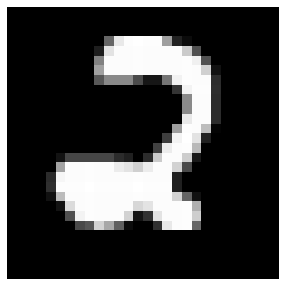

In [86]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Create Mini Batches

In [87]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Pytorch 

In [88]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

## Use GPU when available

In [89]:
torch.cuda.is_available()

True

In [90]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Accuracy

In [91]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

# Train

In [92]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    epoch_acc = 0.0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (epoch_acc < 0.95 and i < 100):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr_list.append(optimizer.param_groups[0]['lr'])
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        # print(f'Epoch: {len(acc_list)}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list

## List Operations

In [93]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first, second)]

In [94]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [95]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

# Experiments

Global var

In [96]:
MAX_ITERATIONS = 20

layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}


## Fixed

In [97]:
def Fixed() -> list | list | list | float | float:
    modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


    start.record()
    fixed_acc_list, fixed_cost_list, fixed_lr_list = train(modelFixed, optimizer,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    fixed_time = start.elapsed_time(end)

    fixed_acc = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

    return fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc


In [98]:
resultados['fixed'] = {}
resultados['fixed']['val_acc_list'] = [0] * epochs
resultados['fixed']['test_acc'] = 0
resultados['fixed']['cost'] = [0] * epochs
resultados['fixed']['time'] = 0

for _ in range(MAX_ITERATIONS):
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc = Fixed()
    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)
    resultados['fixed']['test_acc'] += fixed_acc
    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)
    resultados['fixed']['time'] += fixed_time

#Saving results
resultados['fixed']['name'] = 'Fijo'
resultados['fixed']['lr'] = fixed_lr_list
resultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS
resultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))
resultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))
resultados['fixed']['time'] = resultados['fixed']['time'] / MAX_ITERATIONS

## Decreciente (Pytorch)

In [99]:
def Decay() -> list | list | list | list | float:
    modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1, verbose=False)

    start.record()
    decay_acc_list, decay_cost_list, decay_lr_list = train(modelDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    decay_time = start.elapsed_time(end)

    decay_acc = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)
    
    return decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc

In [100]:
resultados['decay'] = {}
resultados['decay']['val_acc_list'] = [0] * epochs
resultados['decay']['test_acc'] = 0
resultados['decay']['cost'] = [0] * epochs
resultados['decay']['time'] = 0

for _ in range(MAX_ITERATIONS):
    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc = Decay()
    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)
    resultados['decay']['test_acc'] += decay_acc
    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)
    resultados['decay']['time'] += decay_time

#Saving results
resultados['decay']['name'] = 'Decreciente'
resultados['decay']['lr'] = decay_lr_list
resultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS
resultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))
resultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))
resultados['decay']['time'] = resultados['decay']['time'] / MAX_ITERATIONS

## Cyclic Vanilla

In [101]:
def Cyclic() -> list | list | list | list | float:
    modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list= train(modelCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclic_time = start.elapsed_time(end)

    cyclic_acc = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

    return cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc

In [102]:
resultados['cyclic'] = {}
resultados['cyclic']['val_acc_list'] = [0]* epochs
resultados['cyclic']['test_acc'] = 0
resultados['cyclic']['cost'] = [0] * epochs
resultados['cyclic']['time'] = 0

for _ in range(MAX_ITERATIONS):
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc = Cyclic()
    resultados['cyclic']['val_acc_list'] = SumList(resultados['cyclic']['val_acc_list'], cyclic_acc_list)
    resultados['cyclic']['test_acc'] += cyclic_acc
    resultados['cyclic']['cost'] = SumList(resultados['cyclic']['cost'], cyclic_cost_list)
    resultados['cyclic']['time'] += cyclic_time

#Saving results
resultados['cyclic']['name'] = 'Ciclico'
resultados['cyclic']['lr'] = cyclic_lr_list
resultados['cyclic']['test_acc'] = resultados['cyclic']['test_acc'] / MAX_ITERATIONS
resultados['cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclic']['cost'], MAX_ITERATIONS))
resultados['cyclic']['time'] = resultados['cyclic']['time'] / MAX_ITERATIONS

## Cyclic Class

In [103]:
from torch.optim import Optimizer

import types
import math
from torch._six import inf
from functools import wraps
import warnings
import weakref
import random

class _LRSchedulerGiselt_Denis(object):

    def __init__(self, optimizer, last_epoch=-1, verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]
        self.last_epoch = last_epoch

        # Following https://github.com/pytorch/pytorch/issues/20124
        # We would like to ensure that `lr_scheduler.step()` is called after
        # `optimizer.step()`
        def with_counter(method):
            if getattr(method, '_with_counter', False):
                # `optimizer.step()` has already been replaced, return.
                return method

            # Keep a weak reference to the optimizer instance to prevent
            # cyclic references.
            instance_ref = weakref.ref(method.__self__)
            # Get the unbound method for the same purpose.
            func = method.__func__
            cls = instance_ref().__class__
            del method

            @wraps(func)
            def wrapper(*args, **kwargs):
                instance = instance_ref()
                instance._step_count += 1
                wrapped = func.__get__(instance, cls)
                return wrapped(*args, **kwargs)

            # Note that the returned function here is no longer a bound method,
            # so attributes like `__func__` and `__self__` no longer exist.
            wrapper._with_counter = True
            return wrapper

        self.optimizer.step = with_counter(self.optimizer.step)
        self.verbose = verbose

        self._initial_step()

    def _initial_step(self):
        """Initialize step counts and performs a step"""
        self.optimizer._step_count = 0
        self._step_count = 0
        self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Args:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_last_lr(self):
        """ Return last computed learning rate by current scheduler.
        """
        return self._last_lr

    def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        raise NotImplementedError

    def print_lr(self, is_verbose, group, lr, epoch=None):
        """Display the current learning rate.
        """
        if is_verbose:
            if epoch is None:
                print('Adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(group, lr))
            else:
                epoch_str = ("%.2f" if isinstance(epoch, float) else
                             "%.5d") % epoch
                print('Epoch {}: adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(epoch_str, group, lr))


    def step(self, epoch=None):
        # Raise a warning if old pattern is detected
        # https://github.com/pytorch/pytorch/issues/20124
        if self._step_count == 1:
            if not hasattr(self.optimizer.step, "_with_counter"):
                warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
                              "initialization. Please, make sure to call `optimizer.step()` before "
                              "`lr_scheduler.step()`. See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

            # Just check if there were two first lr_scheduler.step() calls before optimizer.step()
            elif self.optimizer._step_count < 1:
                warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
                              "In PyTorch 1.1.0 and later, you should call them in the opposite order: "
                              "`optimizer.step()` before `lr_scheduler.step()`.  Failure to do this "
                              "will result in PyTorch skipping the first value of the learning rate schedule. "
                              "See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
        self._step_count += 1

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False

        with _enable_get_lr_call(self):
            if epoch is None:
                self.last_epoch += 1
                values = self.get_lr()
            else:
                warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                self.last_epoch = epoch
                if hasattr(self, "_get_closed_form_lr"):
                    values = self._get_closed_form_lr()
                else:
                    values = self.get_lr()

        for i, data in enumerate(zip(self.optimizer.param_groups, values)):
            param_group, lr = data
            param_group['lr'] = lr
            self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

class CyclicLRGiselt_Denis(_LRSchedulerGiselt_Denis):
    r"""Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.

    Cyclical learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.

    This class has three built-in policies, as put forth in the paper:

    * "triangular": A basic triangular cycle without amplitude scaling.
    * "triangular2": A basic triangular cycle that scales initial amplitude by half each cycle.
    * "exp_range": A cycle that scales initial amplitude by :math:`\text{gamma}^{\text{cycle iterations}}`
      at each cycle iteration.

    This implementation was adapted from the github repo: `bckenstler/CLR`_

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for each parameter group.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size_up (int): Number of training iterations in the
            increasing half of a cycle. Default: 2000
        step_size_down (int): Number of training iterations in the
            decreasing half of a cycle. If step_size_down is None,
            it is set to step_size_up. Default: None
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            If specified, then 'mode' is ignored.
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Lower momentum boundaries in the cycle
            for each parameter group. Note that momentum is cycled inversely
            to learning rate; at the peak of a cycle, momentum is
            'base_momentum' and learning rate is 'max_lr'.
            Default: 0.8
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            The momentum at any cycle is the difference of max_momentum
            and some scaling of the amplitude; therefore
            base_momentum may not actually be reached depending on
            scaling function. Note that momentum is cycled inversely
            to learning rate; at the start of a cycle, momentum is 'max_momentum'
            and learning rate is 'base_lr'
            Default: 0.9
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.

    Example:
        >>> # xdoctest: +SKIP
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()


    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self,
                 optimizer,
                 base_lr,
                 max_lr,
                 step_size_up=2000,
                 step_size_down=None,
                 mode='triangular',
                 gamma=1.,
                 scale_fn=None,
                 scale_mode='cycle',
                 cycle_momentum=True,
                 base_momentum=0.8,
                 max_momentum=0.9,
                 last_epoch=-1,
                 verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        
        self.direction_up = True
        self.half_cycle_steps = 0

        base_lrs = self._format_param('base_lr', optimizer, base_lr)
        if last_epoch == -1:
            for lr, group in zip(base_lrs, optimizer.param_groups):
                group['lr'] = lr

        self.max_lrs = self._format_param('max_lr', optimizer, max_lr)

        self.step_size_up = float(step_size_up)
        self.step_size_down = float(step_size_down) if step_size_down is not None else step_size_up
        self.total_size = self.step_size_up + self.step_size_down
        self.step_ratio = step_size_up / self.total_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            self._scale_fn_custom = None
            if self.mode == 'triangular':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular2_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self._scale_fn_ref = weakref.WeakMethod(self._exp_range_scale_fn)
                self.scale_mode = 'iterations'
        else:
            self._scale_fn_custom = scale_fn
            self._scale_fn_ref = None
            self.scale_mode = scale_mode

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
            self.base_momentums = [group['momentum'] for group in optimizer.param_groups]
            self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)

        super(CyclicLRGiselt_Denis, self).__init__(optimizer, last_epoch, verbose)
        self.base_lrs = base_lrs

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def scale_fn(self, x):
        if self._scale_fn_custom is not None:
            # print(self.half_cycle_steps, x)
            return self._scale_fn_custom(x)

        else:
            return self._scale_fn_ref()(x)

    def scale_fn_rand(self, x, y):
        return random.uniform(x, y)

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        """Calculates the learning rate at batch index. This function treats
        `self.last_epoch` as the last batch index.

        If `self.cycle_momentum` is ``True``, this function has a side effect of
        updating the optimizer's momentum.
        """
        

        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        cycle = math.floor(1 + self.last_epoch / self.total_size)
        x = 1. + self.last_epoch / self.total_size - cycle
        if x <= self.step_ratio:
            scale_factor = x / self.step_ratio
        else:
            scale_factor = (x - 1) / (self.step_ratio - 1)

        lrs = []
        for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
            base_height = (max_lr - base_lr) * scale_factor
            if self.scale_mode == 'cycle':

                # print("cycle")
                lr = base_lr + base_height * self.scale_fn(cycle)
            elif self.scale_mode == 'iterations':

                # print("iterations")
                lr = base_lr + base_height * self.scale_fn(self.last_epoch)

            elif self.scale_mode == 'decrecimiento':
                if (self.last_epoch == 0):
                  lr = max_lr
                else: 
                  lr = self.get_last_lr()[0] - base_lr
                  if (lr<0):
                    lr = base_lr

            elif self.scale_mode == 'chipichipi':                               #<--------------------------
                
                '''
                for x in optimizer.param_groups:
                  for each in x['params']:
                    print(each)
                
                for name, param in modelBB.named_parameters():
                  print(param.grad.shape)
                '''

                # print("chipichipi")
                if (self.last_epoch == 0):
                    last_lr = base_lr
                else:
                    last_lr = self.get_last_lr()[0]
                    # print(f"Esto es el ultimo lr {last_lr}")

                if (self.half_cycle_steps == self.step_size_up
                    and self.direction_up == True):
                    #print('Cambio de direccion: bajando')
                    lr = random.uniform(last_lr, max_lr)
                    self.direction_up = False
                    self.half_cycle_steps = 1

                elif (self.half_cycle_steps == self.step_size_down
                    and self.direction_up == False):
                    #print('Cambio de direccion: subiendo')
                    lr = random.uniform(base_lr, last_lr)
                    self.direction_up = True
                    self.half_cycle_steps = 1

                elif (self.direction_up == True):
                    lr = random.uniform(last_lr, max_lr)
                    self.half_cycle_steps += 1

                elif(self.direction_up == False):
                    lr = random.uniform(base_lr, last_lr)
                    self.half_cycle_steps += 1
            #print('base_lr: '+str(base_lr))
            lrs.append(lr)

        if self.cycle_momentum:
            #print('wowo')
            momentums = []
            for base_momentum, max_momentum in zip(self.base_momentums, self.max_momentums):
                base_height = (max_momentum - base_momentum) * scale_factor
                if self.scale_mode == 'cycle':
                    momentum = max_momentum - base_height * self.scale_fn(cycle)
                else:
                    momentum = max_momentum - base_height * self.scale_fn(self.last_epoch)
                #print('momentum: '+str(max_momentum)+' '+str(base_momentum))
                momentums.append(momentum)
            for param_group, momentum in zip(self.optimizer.param_groups, momentums):
                param_group['momentum'] = momentum
            
        return lrs

## Random Cyclic

In [104]:
def CyclicGD() -> list | list | list | list | float:
    import random
    modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

    clr_fn = lambda x, y: random.uniform(x, y)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=3, scale_fn=clr_fn,scale_mode='chipichipi', cycle_momentum=False)

    start.record()
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list= train(modelRandomCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    random_cyclic_time = start.elapsed_time(end)

    random_cyclic_acc = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc

In [105]:
resultados['random_cyclic'] = {}
resultados['random_cyclic']['val_acc_list'] = [0] * epochs
resultados['random_cyclic']['test_acc'] = 0
resultados['random_cyclic']['cost'] = [0] * epochs
resultados['random_cyclic']['time'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc = CyclicGD()
    resultados['random_cyclic']['val_acc_list'] = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['test_acc'] += random_cyclic_acc
    resultados['random_cyclic']['cost'] = SumList(resultados['random_cyclic']['cost'], random_cyclic_cost_list)
    resultados['random_cyclic']['time'] += random_cyclic_time

#Saving results
resultados['random_cyclic']['name'] = 'Random Ciclico'
resultados['random_cyclic']['lr'] = random_cyclic_lr_list
resultados['random_cyclic']['test_acc'] = resultados['random_cyclic']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['cost'], MAX_ITERATIONS))
resultados['random_cyclic']['time'] = resultados['random_cyclic']['time'] / MAX_ITERATIONS

## Nuestro decreciente

In [106]:
def Our_Decay() -> list | list | list | list | float:
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1, verbose=False)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=1,scale_mode='decrecimiento', cycle_momentum=False)

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc

In [107]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time

#Saving results
resultados['our_decay']['name'] = 'Our Decay'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] / MAX_ITERATIONS

## L-BFGS

In [108]:
def LBFGS() -> list | list | list | list | float:
    modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                #line_search_fn="strong_wolfe"
                                )

    lbfgs_cost_list = [0.0]
    lbfgs_acc_list = [0.0]
    modelLBFGS = modelLBFGS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0

    start.record()
    #training
    while (lbfgs_acc_list[-1] < 0.95):
    #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            #print(f'costo: {cost.item()}')
            return cost
        lbfgs_cost_list.append(optimizer.step(closure))
        lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
        #print(f'accuracy: {lbfgs_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_time = start.elapsed_time(end)

    lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_acc_list, lbfgs_cost_list, [0] ,lbfgs_time, lbfgs_acc

In [109]:
# modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
#                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
#                        nn.Linear(in_features=layer2, out_features=10))

# optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
#                               lr=1,
#                               history_size=10, #update history size. What's this?
#                               max_iter=1, #maximal number of iterations per optimization step
#                               #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
#                               #line_search_fn="strong_wolfe"
#                               )

# lbfgs_cost_list = [0.0]
# lbfgs_acc_list = [0.0]
# modelLBFGS = modelLBFGS.to(device=device)
# x_train_tensor = x_train_tensor.to(device=device, dtype=torch.float32)
# y_train_tensor = y_train_tensor.to(device=device, dtype=torch.long)
# i = 0

# start.record()
# #training
# while (lbfgs_acc_list[-1] < 0.95):
#   #print('Iteracion: '+ str(i))
#   def closure():
#     optimizer.zero_grad()
#     scores = modelLBFGS(x_train_tensor)
#     cost = F.cross_entropy(input= scores, target=y_train_tensor.squeeze())
#     cost.backward()
#     #print(f'costo: {cost.item()}')
#     return cost
#   lbfgs_cost_list.append(optimizer.step(closure))
#   lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
#   #print(f'accuracy: {lbfgs_acc_list[-1]}')
#   i+=1
# end.record()

# torch.cuda.synchronize()
# lbfgs_time = start.elapsed_time(end)

# lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

resultados['lbfgs'] = {}
resultados['lbfgs']['val_acc_list'] = [0] * epochs
resultados['lbfgs']['test_acc'] = 0
resultados['lbfgs']['cost'] = [0] * epochs
resultados['lbfgs']['time'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_acc_list, lbfgs_cost_list, lbfgs_lr_list, lbfgs_time, lbfgs_acc = LBFGS()
    resultados['lbfgs']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_acc_list)
    resultados['lbfgs']['test_acc'] += lbfgs_acc
    resultados['lbfgs']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_cost_list)
    resultados['lbfgs']['time'] += lbfgs_time

#Saving results
resultados['lbfgs']['name'] = 'LBFGS'
resultados['lbfgs']['lr'] = lbfgs_lr_list
resultados['lbfgs']['test_acc'] = resultados['lbfgs']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['cost'], MAX_ITERATIONS))
resultados['lbfgs']['time'] = resultados['lbfgs']['time'] / MAX_ITERATIONS

## L-BFGS with line search

In [110]:
def LBFGS_LS() -> list | list | list | list | float:
    modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                line_search_fn="strong_wolfe"
                                )

    lbfgs_ls_cost_list = [0.0]
    lbfgs_ls_acc_list = [0.0]
    modelLBFGS_LS = modelLBFGS_LS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0

    start.record()
    #training
    while (lbfgs_ls_acc_list[-1] < 0.95):
    #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS_LS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            #print(f'costo: {cost.item()}')
            return cost
        lbfgs_ls_cost_list.append(optimizer.step(closure))
        lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
    #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_ls_time = start.elapsed_time(end)

    lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_ls_acc_list, lbfgs_ls_cost_list, [0] ,lbfgs_ls_time, lbfgs_ls_acc

In [111]:
# modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
#                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
#                        nn.Linear(in_features=layer2, out_features=10))

# optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
#                               lr=1,
#                               history_size=10, #update history size. What's this?
#                               max_iter=1, #maximal number of iterations per optimization step
#                               #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
#                               line_search_fn="strong_wolfe"
#                               )

# lbfgs_ls_cost_list = [0.0]
# lbfgs_ls_acc_list = [0.0]
# modelLBFGS_LS = modelLBFGS_LS.to(device=device)
# x_train_tensor = x_train_tensor.to(device=device, dtype=torch.float32)
# y_train_tensor = y_train_tensor.to(device=device, dtype=torch.long)
# i = 0

# start.record()
# #training
# while (lbfgs_ls_acc_list[-1] < 0.95):
#   #print('Iteracion: '+ str(i))
#   def closure():
#     optimizer.zero_grad()
#     scores = modelLBFGS_LS(x_train_tensor)
#     cost = F.cross_entropy(input= scores, target=y_train_tensor.squeeze())
#     cost.backward()
#     #print(f'costo: {cost.item()}')
#     return cost

#   lbfgs_ls_cost_list.append(optimizer.step(closure))
#   lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
#   #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
#   i+=1
# end.record()

# torch.cuda.synchronize()
# lbfgs_ls_time = start.elapsed_time(end)

# lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

resultados['lbfgs_ls'] = {}
resultados['lbfgs_ls']['val_acc_list'] = [0] * epochs
resultados['lbfgs_ls']['test_acc'] = 0
resultados['lbfgs_ls']['cost'] = [0] * epochs
resultados['lbfgs_ls']['time'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_ls_acc_list, lbfgs_ls_cost_list, lbfgs_ls_lr_list ,lbfgs_ls_time, lbfgs_ls_acc = LBFGS_LS()
    resultados['lbfgs_ls']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_ls_acc_list)
    resultados['lbfgs_ls']['test_acc'] += lbfgs_ls_acc
    resultados['lbfgs_ls']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_ls_cost_list)
    resultados['lbfgs_ls']['time'] += lbfgs_ls_time

#Saving results
resultados['lbfgs_ls']['name'] = 'LBFGS With LS'
resultados['lbfgs_ls']['lr'] = lbfgs_ls_lr_list
resultados['lbfgs_ls']['test_acc'] = resultados['lbfgs_ls']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs_ls']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs_ls']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['cost'], MAX_ITERATIONS))
resultados['lbfgs_ls']['time'] = resultados['lbfgs_ls']['time'] / MAX_ITERATIONS

## Adam

In [112]:
def Adam() -> list | list | list | list | float:
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc

In [113]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time'] / MAX_ITERATIONS


##Saving results
# resultados['adam'] = {}
# resultados['adam']['name'] = 'Adam'
# resultados['adam']['lr'] = [0]
# resultados['adam']['val_acc_list'] = adam_acc_list
# resultados['adam']['test_acc'] = adam_acc
# resultados['adam']['cost'] = adam_cost_list
# resultados['adam']['time'] = adam_time


## Momentum

In [114]:
def SGDM() -> list | list | list | list | float:
    modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
    start.record()
    SGDM_acc_list, SGDM_cost_list,SGDM_lr_list = train(modelSGDM, optimiserSGDM,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    SGDM_time = start.elapsed_time(end)

    SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

    return SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc

In [115]:
resultados['SGDM'] = {}
resultados['SGDM']['val_acc_list'] = [0] * epochs
resultados['SGDM']['test_acc'] = 0
resultados['SGDM']['cost'] = [0] * epochs
resultados['SGDM']['time'] = 0

for _ in range(MAX_ITERATIONS):
    SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc = SGDM()
    resultados['SGDM']['val_acc_list'] = SumList(resultados['SGDM']['val_acc_list'], SGDM_acc_list)
    resultados['SGDM']['test_acc'] += SGDM_acc
    resultados['SGDM']['cost'] = SumList(resultados['SGDM']['cost'], SGDM_cost_list)
    resultados['SGDM']['time'] += SGDM_time

#Saving results
resultados['SGDM']['name'] = 'SGDM'
resultados['SGDM']['lr'] = SGDM_lr_list
resultados['SGDM']['test_acc'] = resultados['SGDM']['test_acc'] / MAX_ITERATIONS
resultados['SGDM']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['SGDM']['val_acc_list'], MAX_ITERATIONS))
resultados['SGDM']['cost'] = DeleteZerosFromList(DivideList(resultados['SGDM']['cost'], MAX_ITERATIONS))
resultados['SGDM']['time'] = resultados['SGDM']['time'] / MAX_ITERATIONS

# #Saving results
# resultados['SGDM'] = {}
# resultados['SGDM']['name'] = 'Momentum'
# resultados['SGDM']['lr'] = [0]
# resultados['SGDM']['val_acc_list'] = SGDM_acc_list
# resultados['SGDM']['test_acc'] = SGDM_acc
# resultados['SGDM']['cost'] = SGDM_cost_list
# resultados['SGDM']['time'] = SGDM_time

## RMSProp

In [116]:
def RMSP() -> list | list | list | list | float:
    modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
    start.record()
    RMSP_acc_list, RMSP_cost_list,RMSP_lr_list = train(modelRMSP, optimiserRMSP,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    RMSP_time = start.elapsed_time(end)

    RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

    return RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc

In [117]:
resultados['RMSP'] = {}
resultados['RMSP']['val_acc_list'] = [0] * epochs
resultados['RMSP']['test_acc'] = 0
resultados['RMSP']['cost'] = [0] * epochs
resultados['RMSP']['time'] = 0

for _ in range(MAX_ITERATIONS):
    RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc = SGDM()
    resultados['RMSP']['val_acc_list'] = SumList(resultados['RMSP']['val_acc_list'], RMSP_acc_list)
    resultados['RMSP']['test_acc'] += RMSP_acc
    resultados['RMSP']['cost'] = SumList(resultados['RMSP']['cost'], RMSP_cost_list)
    resultados['RMSP']['time'] += RMSP_time

#Saving results
resultados['RMSP']['name'] = 'RMSP'
resultados['RMSP']['lr'] = RMSP_lr_list
resultados['RMSP']['test_acc'] = resultados['RMSP']['test_acc'] / MAX_ITERATIONS
resultados['RMSP']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['RMSP']['val_acc_list'], MAX_ITERATIONS))
resultados['RMSP']['cost'] = DeleteZerosFromList(DivideList(resultados['RMSP']['cost'], MAX_ITERATIONS))
resultados['RMSP']['time'] = resultados['RMSP']['time'] / MAX_ITERATIONS

# #Saving results
# resultados['RMSP'] = {}
# resultados['RMSP']['name'] = 'RMSProp'
# resultados['RMSP']['lr'] = [0]
# resultados['RMSP']['val_acc_list'] = RMSP_acc_list ## Media de esto
# resultados['RMSP']['test_acc'] = RMSP_acc ## Media de esto
# resultados['RMSP']['cost'] = RMSP_cost_list ## Media de esto
# resultados['RMSP']['time'] = RMSP_time ## Media de esto

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados

In [118]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(1000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)


## Traza de tasas de aprendizaje no adaptativas

C:\Users\denis\AppData\Local\Temp\ipykernel_28412\3956678165.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


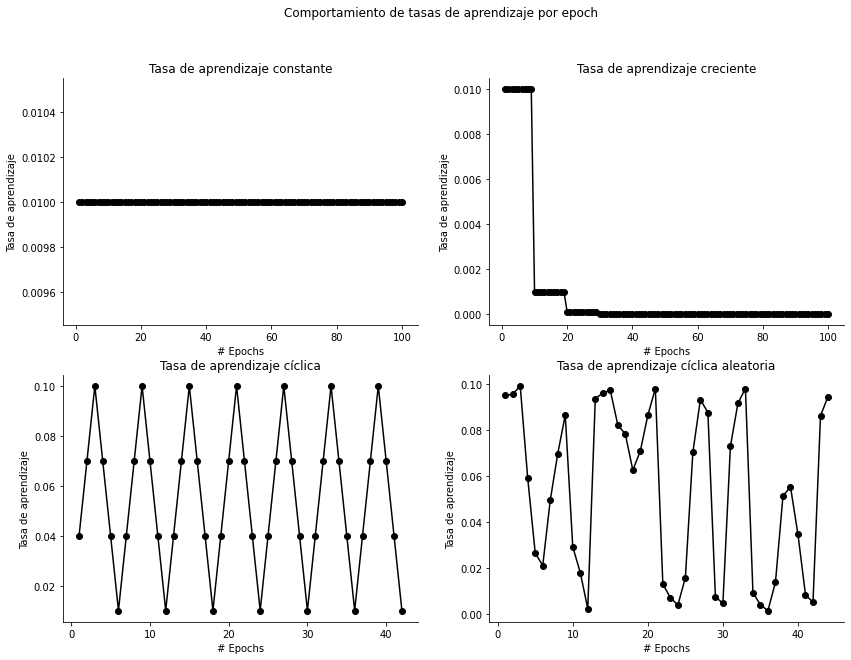

In [119]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(2,2,figsize=(14, 10))

method = [fixed_lr_list, decay_lr_list, cyclic_lr_list, random_cyclic_lr_list, adam_lr_list,SGDM_lr_list,RMSP_lr_list]
names = ['Tasa de aprendizaje constante', 'Tasa de aprendizaje creciente', 'Tasa de aprendizaje cíclica', 'Tasa de aprendizaje cíclica aleatoria', 'TA con Adam','TA con Momentum','TA con RMSProp']
i = 0
for a in range(2):
  for b in range(2):
    ax[a,b].plot(range(len(method[i]))[1:], 
            method[i][1:], 
            'black',
            marker = 'o')
    #ax[a,b].set_xlim([1, len(method[i])])
    #ax[a,b].set_ylim([0, max(method[i]) + 0.01])
    ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
    ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    #ax[a,b].xaxis.set_major_locator(MultipleLocator(len(method[i])//4))
    #ax[a,b].xaxis.set_minor_locator(MultipleLocator(len(method[i])//4))
    ax[a,b].set_title(names[i])
    i+=1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

## Tiempos por epoch

In [120]:
resultados_df

,val_acc_list,test_acc,cost,time,name,lr,val_acc,epochs
fixed,"[0.3778564453125, 0.5964599609375, 0.680297851...",1847.56%,"[2.231410467624664, 2.150319278240204, 2.06237...",16.07,Fijo,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",92.6%,99
decay,"[0.3613525390625, 0.5827392578125, 0.671716308...",1619.19%,"[2.2321651220321654, 2.1527655363082885, 2.067...",17.39,Decreciente,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",81.96%,99
cyclic,"[0.36158447265625, 0.732666015625, 0.819519042...",1887.5%,"[2.230029034614563, 1.8861099004745483, 1.0830...",6.96,Ciclico,"[0.0, 0.040000000000000015, 0.0699999999999999...",94.5%,37
random_cyclic,"[0.64251708984375, 0.79176025390625, 0.8235229...",1889.31%,"[1.8815306961536407, 1.1694076836109162, 0.826...",7.15,Random Ciclico,"[0.0, 0.0951361760840552, 0.09565533808892965,...",94.3%,36
our_decay,"[0.116162109375, 0.7898193359375, 0.7951660156...",1888.75%,"[2.3015360236167908, 1.3486210525035858, 1.247...",7.64,Our Decay,"[0.0, 0.1, 0.001, 0.1, 0.001, 0.1, 0.001, 0.1,...",94.23%,39
lbfgs,"[0.0994384765625, 0.40408935546875, 0.63267822...",1888.55%,"[tensor(2.3054, device='cuda:0', grad_fn=<DivB...",4.40,LBFGS,[0],93.93%,29
lbfgs_ls,"[0.0049719238281250005, 0.051991577148437496, ...",1889.55%,"[tensor(0.1153, device='cuda:0', grad_fn=<DivB...",8.25,LBFGS With LS,[0],9.41%,29
adam,"[0.82896728515625, 0.92791748046875, 0.9510375...",1907.64%,"[0.6943254619836807, 0.26608802154660227, 0.17...",0.59,Adam,"[0.0, 0.01, 0.01, 0.01, 0.01]",95.1%,3
SGDM,"[0.7109619140625, 0.80252685546875, 0.86112060...",1887.5%,"[1.9746383428573608, 1.1594529807567597, 0.614...",4.34,SGDM,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",94.55%,23
RMSP,"[0.7092529296875, 0.80238037109375, 0.85861816...",1887.87%,"[1.9792809903621673, 1.170724368095398, 0.6115...",4.20,RMSP,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",94.58%,23


In [125]:
resultados_df[['name','test_acc','val_acc','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_28412\3725576838.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','test_acc','val_acc','time']].style.hide_index()


name,test_acc,val_acc,time
Fijo,1847.56%,92.6%,16.070000
Decreciente,1619.19%,81.96%,17.390000
Ciclico,1887.5%,94.5%,6.960000
Random Ciclico,1889.31%,94.3%,7.150000
Our Decay,1888.75%,94.23%,7.640000
LBFGS,1888.55%,93.93%,4.400000
LBFGS With LS,1889.55%,9.41%,8.250000
Adam,1907.64%,95.1%,0.590000
SGDM,1887.5%,94.55%,4.340000
RMSP,1887.87%,94.58%,4.200000


## Convergencia en iteraciones

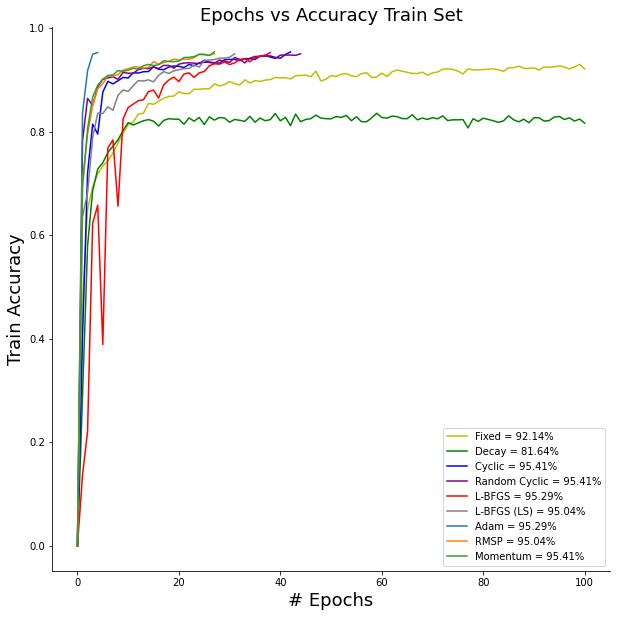

In [122]:
x_axis = range(len(decay_acc_list))
y_axis = np.linspace(0,5,10)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(fixed_acc_list)),fixed_acc_list, 'y', label='Fixed = {acc}%'.format(acc = round(fixed_acc_list[-1] * 100 , 2)))
ax.plot(range(len(decay_acc_list)), decay_acc_list, 'g', label='Decay = {acc}%'.format(acc = round(decay_acc_list[-1] * 100, 2)))
ax.plot(range(len(cyclic_acc_list)), cyclic_acc_list, 'b', label='Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))
ax.plot(range(len(random_cyclic_acc_list)), random_cyclic_acc_list, 'purple', label='Random Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))
ax.plot(range(len(lbfgs_acc_list)), lbfgs_acc_list, 'r', label='L-BFGS = {acc}%'.format(acc = round(lbfgs_acc_list[-1] * 100, 2)))
ax.plot(range(len(lbfgs_ls_acc_list)), lbfgs_ls_acc_list, 'grey', label='L-BFGS (LS) = {acc}%'.format(acc = round(lbfgs_ls_acc_list[-1] * 100, 2)))

ax.plot(range(len(adam_acc_list)),adam_acc_list, label='Adam = {acc}%'.format(acc = round(adam_acc_list[-1] * 100 , 2)))
ax.plot(range(len(RMSP_acc_list)), RMSP_acc_list, label='RMSP = {acc}%'.format(acc = round(RMSP_acc_list[-1] * 100, 2)))
ax.plot(range(len(SGDM_acc_list)), SGDM_acc_list, label='Momentum = {acc}%'.format(acc = round(SGDM_acc_list[-1] * 100, 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)
plt.xlabel('# Epochs', fontsize = 18)
plt.ylabel('Train Accuracy', fontsize = 18)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Precision en el conjunto de datos de prueba

In [123]:
print("Tasa de aprendizaje fija| " + str(fixed_acc))
print("Tasa de aprendizaje decreciente| " + str(decay_acc))
print("Tasa de aprendizaje ciclica | " + str(cyclic_acc))
print("Tasa de aprendizaje ciclica random | " + str(random_cyclic_acc))
print("L-BFGS | " + str(lbfgs_acc))
print("L-BFGS con busqueda lineal | " + str(lbfgs_ls_acc))
print("Adam | " + str(adam_acc))
print("RMSP| " + str(RMSP_acc))
print("Momentum| " + str(SGDM_acc))

Tasa de aprendizaje fija| 0.923828125
Tasa de aprendizaje decreciente| 0.814697265625
Tasa de aprendizaje ciclica | 0.94482421875
Tasa de aprendizaje ciclica random | 0.947021484375
L-BFGS | 0.937744140625
L-BFGS con busqueda lineal | 0.94921875
Adam | 0.951904296875
RMSP| 0.95068359375
Momentum| 0.942138671875


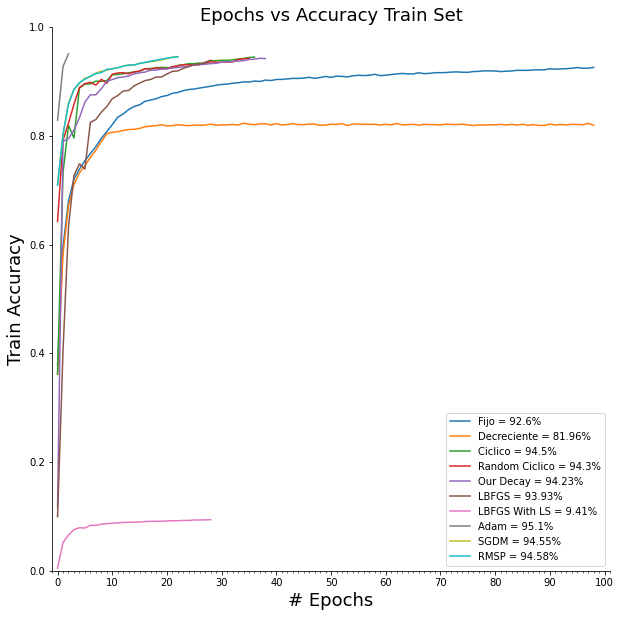

In [133]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

x_axis = range(len(decay_acc_list))
y_axis = np.linspace(0,5,10)

fig, ax = plt.subplots(figsize=(10, 10))

# ax.plot(range(len(fixed_acc_list)),
#         fixed_acc_list, 
#         'y', 
#         label='Fixed = {acc}%'.format(acc = round(fixed_acc_list[-1] * 100 , 2)))

# ax.plot(range(len(decay_acc_list)), 
#         decay_acc_list, 
#         'g', 
#         label='Decay = {acc}%'.format(acc = round(decay_acc_list[-1] * 100, 2)))

# ax.plot(range(len(cyclic_acc_list)), 
#         cyclic_acc_list, 
#         'b', 
#         label='Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))

# ax.plot(range(len(random_cyclic_acc_list)), 
#         random_cyclic_acc_list, 
#         'purple', 
#         label='Random Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))

# ax.plot(range(len(lbfgs_acc_list)), 
#         lbfgs_acc_list, 'r', 
#         label='L-BFGS = {acc}%'.format(acc = round(lbfgs_acc_list[-1] * 100, 2)))

# ax.plot(range(len(lbfgs_ls_acc_list)), 
#         lbfgs_ls_acc_list, 
#         'grey', 
#         label='L-BFGS (LS) = {acc}%'.format(acc = round(lbfgs_ls_acc_list[-1] * 100, 2)))

for k1, _ in resultados.items():
    # print(k1, v1)
    ax.plot(range(len(resultados[k1]['val_acc_list'])),
        resultados[k1]['val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados[k1]['name'],
                                       acc = round(resultados[k1]['val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

ax.set_xlim([-1, len(fixed_acc_list)])
ax.set_ylim([0, 1])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [140]:
resultados['lbfgs_ls']['val_acc_list']

[0.0049719238281250005,
 0.051991577148437496,
 0.0657647705078125,
 0.07581420898437499,
 0.0792254638671875,
 0.07869628906250001,
 0.08364990234375,
 0.0835888671875,
 0.08569763183593751,
 0.086729736328125,
 0.0873223876953125,
 0.0881597900390625,
 0.089068603515625,
 0.0890789794921875,
 0.08961181640625,
 0.0896661376953125,
 0.09052734375,
 0.0909930419921875,
 0.0910443115234375,
 0.091287841796875,
 0.09168151855468751,
 0.09203369140624999,
 0.092086181640625,
 0.092650146484375,
 0.09262756347656251,
 0.093450927734375,
 0.093519287109375,
 0.09375,
 0.0940576171875]